# freud.density.CorrelationFunction
## Orientational Ordering in 2D
The `freud.density` module is intended to compute a variety of quantities that relate spatial distributions of particles with other particles. This example shows how [correlation functions](https://en.wikipedia.org/wiki/Correlation_function_(statistical_mechanics)) can be used to measure orientational order in 2D.

In [1]:
import numpy as np
import freud
import matplotlib.pyplot as plt
import matplotlib.cm
from matplotlib.colors import Normalize

This helper function will make plots of the data we generate in this example.

In [2]:
def plot_data(title, points, angles, values, box, ccf, s=200):
    cmap = matplotlib.cm.viridis
    norm = Normalize(vmin=-np.pi/4, vmax=np.pi/4)
    plt.figure(figsize=(16, 6))
    plt.subplot(121)
    for point, angle, value in zip(points, angles, values):
        plt.scatter(point[0], point[1], marker=(4, 0, np.rad2deg(angle)+45),
                    edgecolor='k', c=[cmap(norm(angle))], s=s)
    plt.title(title)
    plt.gca().set_xlim([-box.Lx/2, box.Lx/2])
    plt.gca().set_ylim([-box.Ly/2, box.Ly/2])
    plt.gca().set_aspect('equal')
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array(angles)
    plt.colorbar(sm)
    plt.subplot(122)
    plt.title('Orientation Spatial Autocorrelation Function')
    ccf.plot(ax=plt.gca())
    plt.xlabel(r'$r$')
    plt.ylabel(r'$C(r)$')
    plt.show()

First, let's generate a 2D structure with perfect orientational order and slight positional disorder (the particles are not perfectly on a grid, but they are perfectly aligned). The color of the particles corresponds to their angle of rotation, so all the particles will be the same color to begin with.

We create a `freud.density.CorrelationFunction` object to compute the correlation functions. Given a particle orientation $\theta$, we compute its complex orientation value (the quantity we are correlating) as $s = e^{4i\theta}$, to account for the fourfold symmetry of the particles. We will compute the correlation function $C(r) = \left\langle s^*_1(0) \cdot s_2(r) \right\rangle$ by taking the average over all particle pairs and binning the results into a histogram by the distance $r$ between the particles.

When we compute the correlations between particles, we must use the complex conjugate of the `values` array for one of the arguments. This way, if $\theta_1$ is close to $\theta_2$, then we get $\left(e^{4i\theta_1}\right)^* \cdot \left(e^{4i\theta_2}\right) = e^{4i(\theta_2-\theta_1)} \approx e^0 = 1$.

This system has perfect spatial correlation of the particle orientations, so we see $C(r) = 1$ for all values of $r$.

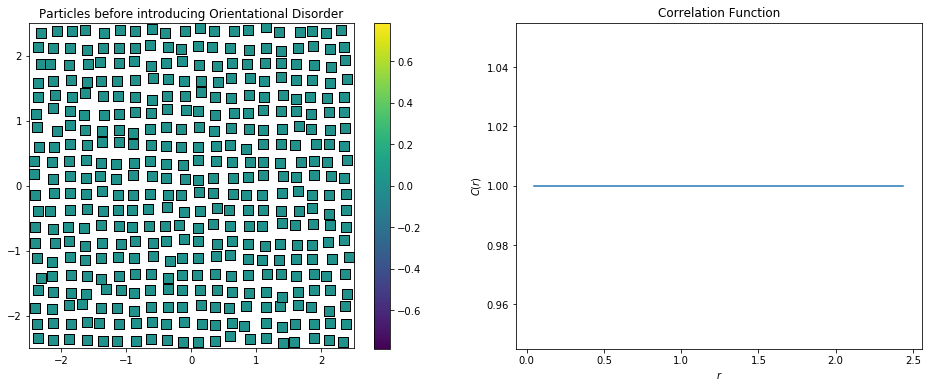

In [3]:
def make_particles(L, repeats):
    uc = freud.data.UnitCell.square()
    return uc.generate_system(num_replicas=repeats, scale=L/repeats, sigma_noise=5e-3*L)

# Make a small system
box, points = make_particles(L=5, repeats=20)

# All the particles begin with their orientation at 0
angles = np.zeros(len(points))
values = np.array(np.exp(angles * 4j))

# Create the CorrelationFunction compute object and compute the correlation function
ccf = freud.density.CorrelationFunction(bins=25, r_max=box.Lx/2.01)
ccf.compute((box, points), np.conj(values), points, values)


plot_data('Particles before introducing Orientational Disorder',
          points, angles, values, box, ccf)

Now we will generate random angles from $-\frac{\pi}{4}$ to $\frac{\pi}{4}$, which orients our squares randomly. The four-fold symmetry of the squares means that the space of unique angles is restricted to a range of $\frac{\pi}{2}$. Again, we compute a complex value for each particle, $s = e^{4i\theta}$.

Because we have purely random orientations, we expect no spatial correlations in the plot above. As we see, $C(r) \approx 0$ for all $r$.

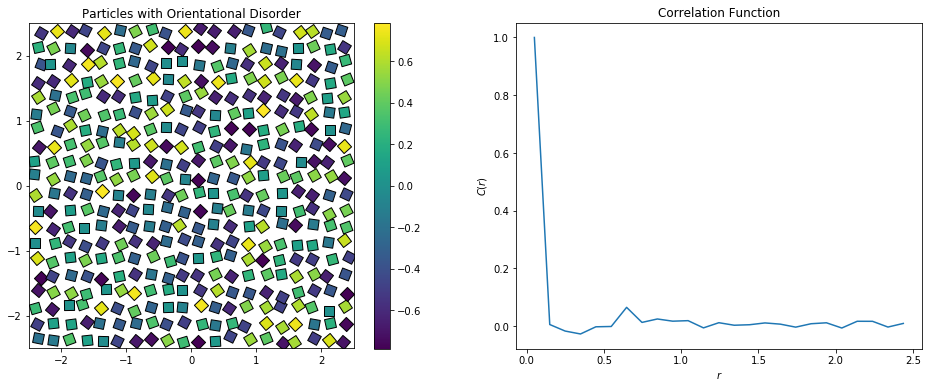

In [4]:
# Change the angles to values randomly drawn from a uniform distribution
angles = np.random.uniform(-np.pi/4, np.pi/4, size=len(points))
values = np.exp(angles * 4j)

# Recompute the correlation functions
ccf.compute((box, points), np.conj(values), points, values)

plot_data('Particles with Orientational Disorder',
          points, angles, values, box, ccf)

The plot below shows what happens when we intentionally introduce a correlation length by adding a spatial pattern to the particle orientations. At short distances, the correlation is very high. As $r$ increases, the oppositely-aligned part of the pattern some distance away causes the correlation to drop.

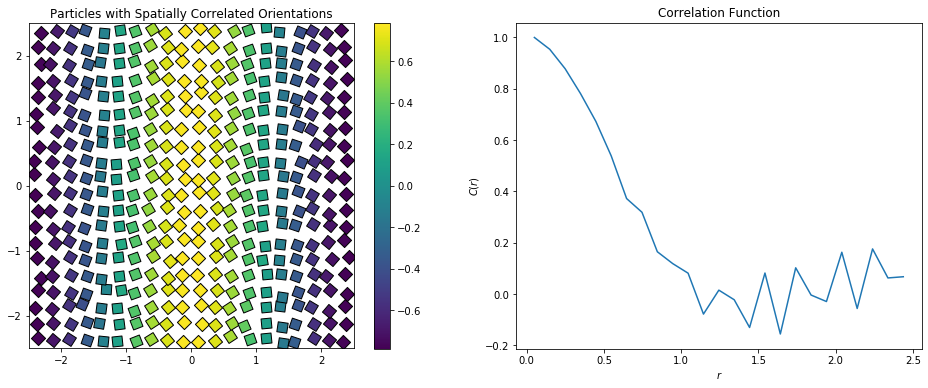

In [5]:
# Use angles that vary spatially in a pattern
angles = np.pi/4 * np.cos(2*np.pi*points[:, 0]/box.Lx)
values = np.exp(angles * 4j)

# Recompute the correlation functions
ccf.compute((box, points), np.conj(values), points, values)

plot_data('Particles with Spatially Correlated Orientations',
          points, angles, values, box, ccf)

In the larger system shown below, we see the spatial autocorrelation rise and fall with damping oscillations.

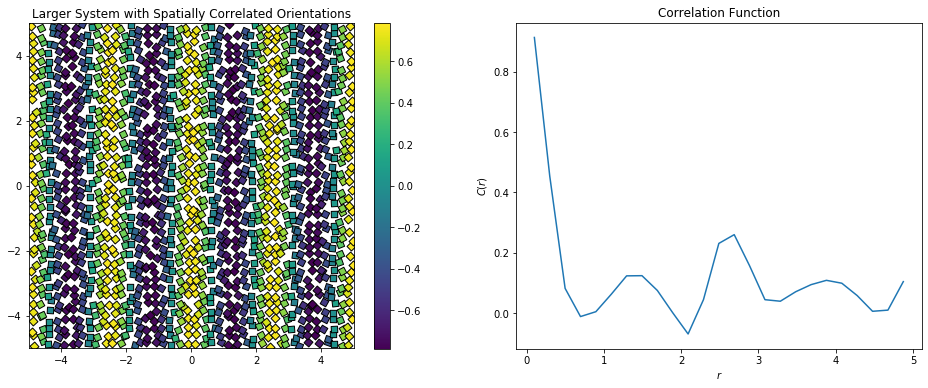

In [6]:
# Make a large system
box, points = make_particles(L=10, repeats=40)

# Use angles that vary spatially in a pattern
angles = np.pi/4 * np.cos(8*np.pi*points[:, 0]/box.Lx)
values = np.exp(angles * 4j)

# Create a CorrelationFunction compute object
ccf = freud.density.CorrelationFunction(bins=25, r_max=box.Lx/2.01)
ccf.compute((box, points), np.conj(values), points, values)

plot_data('Larger System with Spatially Correlated Orientations',
          points, angles, values, box, ccf, s=80)